**1** (code cell)

In [331]:
import numpy as np
import matplotlib.pyplot as plt

**2** (code cell)

In [332]:
class Maze:
    """Represents a maze environment."""
    def __init__(self, maze, start_position, goal_position):
        """
        Create Maze object given maze configuration in the parameters and with
        start and goal positions.

        Instance Variables:
        :self.maze: numpy ndarray, Represents the layout of the maze.
        :self.maze_height: int, Represents the height of the maze
          (number of rows).
        :self.maze_width: int, Represents the width of the maze
          (number of columns).
        :self.start_position: tuple, Represents the starting position
          (row, column) in the maze.
        :self.goal_position: tuple, Represents the goal position (row, column)
          in the maze.

        Parameters:
        :param maze: numpy ndarray, Represents the layout of the maze where 0
          represents a clear path and 1 represents a wall.
        :param start_position: tuple, Represents the starting position
          (row, column) in the maze.
        :param goal_position: tuple, Represents the goal position (row, column)
          in the maze.
        """
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position

    def show_maze(self, path=None):
        """
        Displays the maze with start and goal positions marked.

        :param path: list of tuples, Represents the path taken by the agent.
        """
        plt.figure(figsize=(3,3))
        plt.imshow(self.maze, cmap='Blues')
        plt.text(self.start_position[0], self.start_position[1], 'S',
                  ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G',
                  ha='center', va='center', color='green', fontsize=20)
        if path:
            for position in path:
                plt.text(position[0]-0.1, position[1], "o", va='center',
                         color='black', fontsize=15)
        for i in range(self.maze.shape[0] + 1):
            plt.axhline(i - 0.5, color='black', linewidth=0.5)
        for j in range(self.maze.shape[1] + 1):
            plt.axvline(j - 0.5, color='black', linewidth=0.5)
        plt.xticks([]), plt.yticks([])
        plt.grid(color='black', linewidth=2)
        plt.show()

#### **Create a `Maze` instance**


**3** (code cell)

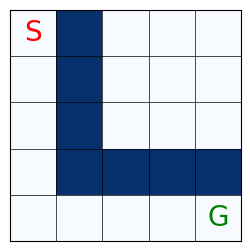

In [333]:
maze_layout = np.array([
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0]
])

maze = Maze(maze_layout, (0, 0), (4, 4))
maze.show_maze()

#### **Robot Actions**

The robot can take the following actions, each represented as a tuple of two values: (row change, column change)

- **North:** Moving one step up, reducing the row index by 1, (-1, 0)
- **South:** Moving one step down, increasing the row index by 1, (1, 0)
- **West:** Moving one step to the left, reducing the column index by 1, (0, -1)
- **East:** Moving one step to the right, increasing the column index by 1, (0, 1)


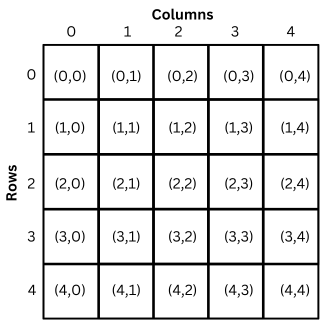

**4** (code cell)

In [334]:
actions = [(-1, 0),
          (1, 0),
          (0, -1),
          (0, 1)]

**5** (code cell)

In [335]:
class QLearningAgent:
    """Represents a Q-learning agent for navigating a maze environment."""
    def __init__(self, maze, learning_rate=0.9, discount_factor=0.1,
                 exploration_start=1.0, exploration_end=0.5,
                 num_episodes=1000):
        """
        Instance Variables:
        :self.q_table: numpy ndarray, to store Q-values
        :self.learning_rate: float, Learning rate
        :self.discount_factor: float, Discount factor for future rewards
        :self.exploration_start: float, Initial exploration rate
        :self.exploration_end: float, Final exploration rate
        :self.num_episodes: int, Number of episodes for training

        Parameters:
        :param maze: Maze
        :param learning_rate: float, Learning rate
        :param discount_factor: float, Discount factor for future rewards
        :param exploration_start: float, Initial exploration rate
        :param exploration_end: float, Final exploration rate
        :param num_episodes: int, Number of episodes for training
        """
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, len(actions)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        """
        Calculates the exploration rate for the current episode.

        :param current_episode: int, Current episode number.
        :return: float, Exploration rate for the current episode
        """
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, current_episode):
        """
        Selects an action for the given state using epsilon-greedy strategy.

        :param state: tuple, Current state (row, column) in the maze
        :param current_episode: int, Current episode number
        :return: int, index of the selected action (0 for North, 1 for South, 2
          for West, 3 for East).
        """
        exploration_rate = self.get_exploration_rate(current_episode)
        if np.random.rand() < exploration_rate:
            return np.random.randint(len(actions))
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, next_state, reward):
        """
        Updates the Q-table based on the Q-learning algorithm.

        :param state: tuple, Current state (row, column) in the maze.
        :param action: int, Index of the action taken.
        :param next_state: tuple, Next state (row, column) in the maze.
        :param reward: float, Reward received for the action.
        """
        best_next_action = np.argmax(self.q_table[next_state])
        current_q_value = self.q_table[state][action]
        max_future_reward = self.q_table[next_state][best_next_action]
        # We use `e_d_c_r` to mean expected discounted cumulative reward
        e_d_c_r = self.learning_rate * (reward + self.discount_factor * max_future_reward - current_q_value)
        new_q_value = current_q_value + e_d_c_r
        self.q_table[state][action] = new_q_value

**6** (code cell)

In [336]:
goal_reward = 100
wall_edge_penalty = -10
step_penalty = -1

**7** (code cell)

In [337]:
def finish_episode(agent, maze, current_episode, train=True):
    """
    Simulates the agent's movements in the maze for a single episode.

    :param agent: QLearningAgent object, Q-learning agent navigating the maze.
    :param maze: Maze object, Maze environment.
    :param current_episode: int, Current episode number.
    :param train: bool, Flag to update (or not) Q-table during training
      (default=True).
    :return: tuple of three values
      - episode_reward: float, Cumulative reward obtained during the episode.
      - episode_step: int, Total number of steps taken during the episode.
      - path: list of states visited during the episode.
    """
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]

    while not is_done:
        action = agent.get_action(current_state, current_episode)

        next_state = (current_state[0] + actions[action][0], current_state[1]
                      + actions[action][1])

        if next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width or maze.maze[next_state[1]][next_state[0]] == 1:
            reward = wall_edge_penalty
            next_state = current_state
        elif next_state == maze.goal_position:
            path.append(current_state)
            reward = goal_reward
            is_done = True
        else:
            path.append(current_state)
            reward = step_penalty

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        current_state = next_state

    if next_state != maze.goal_position:
        return 0, episode_step, []

    return episode_reward, episode_step, path


#### **Define `test_agent()` function**

**8** (code cell)

In [338]:
def test_agent(agent, maze, num_episodes=1):
    """
    Evaluates the agent's performance in the maze.

    :param agent: QLearningAgent, Q-learning agent navigating the maze.
    :param maze: Maze
    :param num_episodes: int, Number of episodes to simulate (default=1).
    :return: tuple of two values, corresponding to:
      - episode_step: int, Total number of steps taken during the evaluation
      episode
      - episode_reward: float, Cumulative reward obtained during the evaluation
      episode
    """
    episode_reward, episode_step, path = finish_episode(agent, maze,
                                                        num_episodes,
                                                        train=False)
    if path == []:
      print("No path found")
    else:
      print("Learned Path:")
      for row, col in path:
          print(f"({row}, {col})-> ", end='')
      print("Goal!")

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    maze.show_maze(path)

    return episode_step, episode_reward

**9** (code cell)

Learned Path:
(0, 0)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (0, 3)-> (0, 2)-> (0, 3)-> (0, 4)-> (0, 3)-> (0, 2)-> (0, 3)-> (0, 2)-> (0, 3)-> (0, 2)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 2)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 2)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (0, 3)-> (0, 4)-> (1, 4)-> (2, 4)-> (1, 4)-> (2, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 109
Total reward: -539


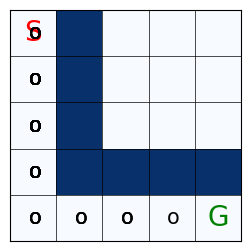

(109, -539)

In [339]:
agent = QLearningAgent(maze)
test_agent(agent, maze)

Did you notice that the untrained robot takes a lot of steps? That is because the robot keeps backtracking and hitting walls. Before it has learned anything, it is blindly going through the maze, choosing its path randomly.

**10** (code cell)

In [340]:
def train_agent(agent, maze, num_episodes=100):
    """
    Trains the Q-learning agent to navigate the maze.

    :param agent: QLearningAgent, agent navigating the maze
    :param maze: Maze
    :param num_episodes: int, Number of episodes for training (default=100)
    """
    episode_rewards = []
    episode_steps = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path = finish_episode(agent, maze,
                                                            episode,
                                                            train=True)

        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
    if episode_reward == 0:
      print ("No path found")
    else:
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.plot(episode_rewards)
      plt.xlabel('Episode')
      plt.ylabel('Cumulative Reward')
      plt.title('Reward per Episode')
      print(episode_rewards)
      average_reward = sum(episode_rewards) / len(episode_rewards)
      print(f"The average reward is: {average_reward}")

      plt.subplot(1, 2, 2)
      plt.plot(episode_steps)
      plt.xlabel('Episode')
      plt.ylabel('Steps Taken')
      plt.ylim(0, 100)
      plt.title('Steps per Episode')

      average_steps = sum(episode_steps) / len(episode_steps)
      print(f"The average steps is: {average_steps}")

      plt.tight_layout()
      plt.show()

#### **Training the agent**

**11** (code cell)

[-853, -559, -597, -411, -227, -1341, -211, -673, -1319, -827, -2567, -2353, -911, -921, -911, -419, -2925, -117, -327, -301, -341, -839, -1081, -499, -73, 61, -1025, -325, -77, -571, -429, -309, -59, -615, -497, -91, -2427, -1555, -1051, -133, -507, -1119, -703, 13, -245, -35, -605, -65, -409, -119, -1401, -157, -71, -117, -103, -423, -425, -591, -559, -177, -109, -507, -55, -883, -311, -145, -279, -247, -125, -83, -93, -685, -59, -1223, -639, -845, -501, -937, -365, -487, -603, -217, -35, -589, -335, -211, -485, -175, -227, -1573, -325, -813, -325, -983, -465, -207, -143, -143, -497, -61]
The average reward is: -555.14
The average steps is: 114.07


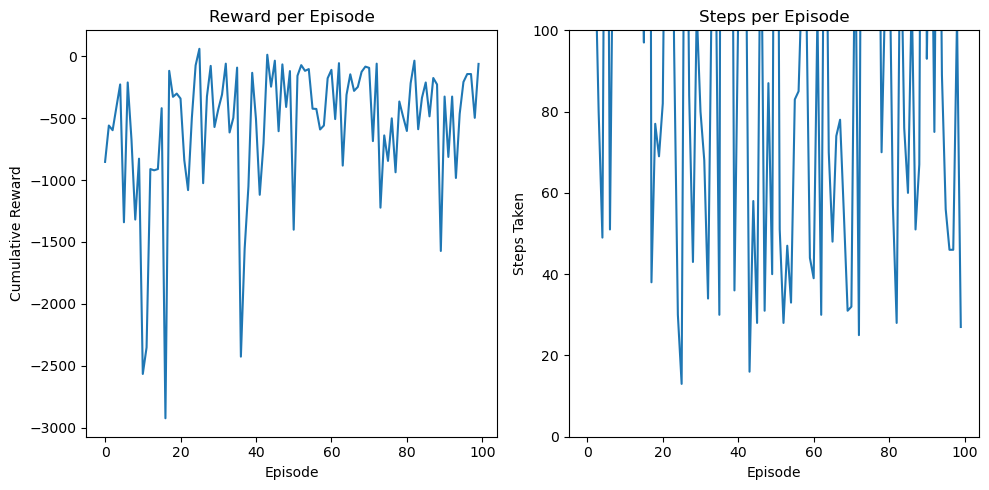

In [341]:
train_agent(agent, maze, num_episodes=100)

#### **Testing the agent after training**

**12** (code cell)

Learned Path:
(0, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (1, 4)-> (2, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 37
Total reward: -143


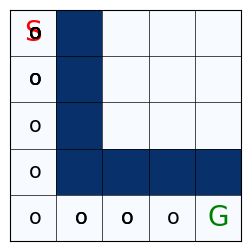

(37, -143)

In [342]:
test_agent(agent, maze, num_episodes=100)

###Observations


Learned Path:
(0, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (0, 3)-> (0, 4)-> (0, 3)-> (0, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 56
Total reward: -297

after the training
Learned Path:
(0, 0)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 8
Total reward: 93

Before training observation:

The agent path before the training is inefficient, taking multiple  unnecessary steps before reaching the goal
The agent took 56 steps to reach the goal 
The total reward by the agent during the process was -297


After training observation:

After training  the agent  path becomes significantly  optimized, taking a direct route to the goal.
The number of steps taken reduces only 8,  indicating a much direct route to the goal.
The total reward by the agent  after the training  increases to 93, indicating that the agent is now making more optimal decision and achieving higher rewards.

Experiment 1: Experimenting with Agent Motion Dynamics
Step Size Adjustment: Modify code cell no. 4 to explore the impact of changing the number of steps the agent takes in each direction. Analyze how this modification affects learning speed and navigation efficiency.
Ans:

The  impact of changing the the number steps
before the training obervations:

Learned Path:
(0, 0)-> (0, 0)-> (2, 0)-> (0, 0)-> (0, 2)-> (2, 2)-> (2, 4)-> (2, 2)-> (0, 2)-> (2, 2)-> (2, 0)-> (4, 0)-> (2, 0)-> (0, 0)-> (0, 2)-> (0, 4)-> (2, 4)-> Goal!
Number of steps: 24
Total reward: 5

The agent path before training is very inefficient, and taking multiple unnecessary steps before reaching the goal.
The agent took 24 steps to reach the goal, which indicates room for optimization
The total reward gained by the agent was only 5, because it was inefficient exploration.

after the training observations

Learned Path:
(0, 0)-> (0, 0)-> (0, 2)-> (0, 4)-> (2, 4)-> Goal!
Number of steps: 4
Total reward: 97

After training, the agent path becomes significantly achieved, taking single route to goal.
The number of steps taken reduce only to 4, indicating the efficient navigation learned by  the agent.
The total reward gained by the agent after training increases to 97 it indicating that the agent is getting the higher rewards.
By reducing the number of steps the agent takes in each direction, a significant improvement in both learning speed and navigation efficiency.
The agent learns to reach the goal in a much shorter path learned during training this learning process and allows the agent to achieve higher rewards with fewer steps, indicating an overall improvement in performance.


Motion Restriction: Also, modify code cell no. 4 to investigate the effects of limiting the agent to three directions instead of four. Assess how this restriction influences the learned policy and adaptability.
ans. 
Before training observations:

No valid path was found before training, indicating that the agent was unable to reach the goal using the available actions because there is no  moving  step down and row indexing increases.
The agent still took 25 steps, which suggests that it might have been exploring the environment randomly.
The total reward obtained before training was 0, indicating that the agent did not achieve any positive outcomes during its exploration.

After training observations:

The agent still couldn't find a valid path to the goal
The agent again took 25 steps, suggesting that the training did not improve the agent's ability to navigate the environment successfully.
The total reward remained at 0 after training, indicating that the agent did not achieve any positive outcomes during the training process.

Limiting the agent to three directions instead of four creates difficulty in finding a path to the goal and the agent into situations where it couldn't progress toward the goal due to the limited set of actions available limitation highlights the importance of providing agents with sufficient action space to navigate complex environments effectively.


Experiment 2: Tuning Learning Parameters
Change the values of learning_rate and discount_factor in code cell no. 5 to observe their effects on the learning process. Investigate different combinations’ impact on convergence speed and the quality of the learned policy.

ans.
learning_rate = 0.1
discount_factor = 0.9

Before the training observations:

Learned Path:
(0, 0)-> (0, 0)-> (2, 0)-> (2, 2)-> (0, 2)-> (2, 2)-> (4, 2)-> Goal!
Number of steps: 9
Total reward: 65

Before training, the agent path to the goal includes some inefficient steps, such as revisiting certain steps in multiple times.
The agent took 9 steps to reach the goal before training.
The total reward obtained by the agent before training was 65, suggesting that it made relatively good decisions.


After the training observations:

Learned Path:
(0, 0)-> (0, 0)-> (0, 2)-> (2, 2)-> (2, 4)-> Goal!
Number of steps: 4
Total reward: 97

After training, the agent path becomes more optimized, taking a more direct route to the goal with fewer unnecessary steps.
The number of steps taken reduces to only 4 after training, indicating a significant improvement in navigation efficiency.
The total reward obtained by the agent after training increases  to 97.

The low learning rate (0.1) implies that the agent updates its values slowly based on the observed rewards and experiences and this can lead to a slower speed as the agent requires more iterations to learn the high discount factor (0.9) indicates that the agent heavily values future rewards compared to immediate rewards this encourages the agent to consider long-term decisions.

Experiment 3: Testing Exploration Settings
Adjust the exploration parameters (exploration_start, exploration_end, and num_episodes) in code cell no. 5 to observe changes in the agent’s behavior. Compare learning curves and the final learned policy for different exploration strategies.

ans:

High exploration start, low exploration end, low number of episodes
exploration_start = 1.0
exploration_end = 0.5
num_episodes = 1000

before the training observations:

Learned Path: (0, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (1, 4)-> (2, 4)-> (1, 4)-> (0, 4)-> (1, 4)-> (2, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 66
Total reward: -343

Before training, the agent path to the goal includes many inefficient steps, with several unnecessary back-and-front movements.
The agent took 66 steps to reach the goal before training, indicating the lack of achieving in the navigation strategy.
The total reward obtained by the agent before training was -343.


after the training observations:
Learned Path: (0, 0)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 3)-> (0, 4)-> (0, 3)-> (0, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 14
Total reward: 51

After training, the agent's path becomes significantly achieved taking a much more direct route to the goal with fewer unnecessary movements.
The number of steps taken reduces to only 14 after training, indicating improvement in navigation efficiency.
The total reward obtained by the agent after training increases to 51, indicating that the agent is now making more decisions and achieving higher rewards.

High exploration at the start (exploration_start = 1.0) encourages the agent to explore the environment extensively and Low exploration at the end (exploration_end = 0.5) suggests that as training progresses the number of episodes (num_episodes = 1000) might limit the agent ability to fully explore and learn the high exploration at the start and low exploration at the end and  the agent undergoes significant improvement in its navigation efficiency and decision making and leading to a more optimized final learned policy and it will  improves knowledge effectively as training progresses and  resulting in improved performance over time.





